# PINNs for the 1D Eikonal Equation (JAX)
This notebook trains two Physics-Informed Neural Networks (PINNs) with JAX, Equinox, and Optax to solve the 1D eikonal equation.


## Problem setup
We solve the 1D eikonal equation
$$ |u_x| = 1, \quad x \in [0, 1] $$
with Dirichlet boundaries $u(0) = 0$ and $u(1) = 0$.
The analytic solution is the distance function $u(x) = x$ (the branch consistent with the boundary data).

The PDE residual is enforced via $u_x^2 - 1 = 0$ so that the gradient is smooth for autodiff.


In [16]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import pandas as pd

USE_64 = False  # toggle if you need extra precision; float64 is slower on many accelerators
jax.config.update("jax_enable_x64", USE_64)

key = jrandom.PRNGKey(0)
print(f"JAX devices: {jax.devices()}")


JAX devices: [CpuDevice(id=0)]


In [17]:
X_MIN, X_MAX = 0.0, 1.0
U_LEFT, U_RIGHT = 0.0, 0.0




def exact_solution(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.min(jnp.stack([x,1-x], axis = -1), axis = -1)

def sample_interior(key: jax.Array, n: int):
    return jrandom.uniform(key, (n,), minval=X_MIN, maxval=X_MAX)

def sample_boundary(key: jax.Array, n: int):
    n_left = n // 2
    n_right = n - n_left
    x_left = jnp.zeros((n_left,)) + X_MIN
    x_right = jnp.zeros((n_right,)) + X_MAX
    x = jnp.concatenate([x_left, x_right])
    targets = jnp.concatenate([
        jnp.zeros_like(x_left) + U_LEFT,
        jnp.zeros_like(x_right) + U_RIGHT,
    ])
    perm = jrandom.permutation(key, x.shape[0])
    return x[perm], targets[perm]


In [18]:
class EikonalPINN(eqx.Module):
    mlp: eqx.nn.MLP
    hard_boundary: bool = eqx.field(static=True)

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        inputs = jnp.atleast_1d(x)
        # inputs = jnp.atleast_1d(x)[..., None]
        out = self.mlp(inputs)
        out = jnp.squeeze(out, axis=-1)
        if self.hard_boundary:
            xi = (x - X_MIN) / (X_MAX - X_MIN)
            base = U_LEFT + xi * (U_RIGHT - U_LEFT)
            out = base + xi * (1.0 - xi) * out
        return out

def make_model(key, *, hidden_layers: int = 4, hidden_width: int = 64, hard_boundary: bool = False) -> EikonalPINN:
    mlp = eqx.nn.MLP(
        in_size=1,
        out_size=1,
        width_size=hidden_width,
        depth=hidden_layers,
        activation=jnp.tanh,
        key=key,
    )
    return EikonalPINN(mlp=mlp, hard_boundary=hard_boundary)

def pde_residual(model: EikonalPINN, x: jnp.ndarray, epsilon: float = 0.0) -> jnp.ndarray:
    def u(x0):
        return model(x0)

    u_x = jax.grad(u)(x)
    u_xx = jax.grad(lambda x0: jax.grad(u)(x0))(x)
    return (u_x ** 2) - 1.0 - epsilon * u_xx


In [19]:
def train_pinn(*, steps: int = 2000, lr: float = 1e-3, interior_samples: int = 1024, boundary_samples: int = 256, hard_boundary: bool = False, seed: int = 42, epsilon: float = 0.0, model: EikonalPINN | None = None):
    key = jrandom.PRNGKey(seed)
    model_key, key = jrandom.split(key)
    if model is None:
        model = make_model(model_key, hard_boundary=hard_boundary)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    history = []

    def loss_fn(model: EikonalPINN, key: jax.Array):
        key, int_key, bc_key = jrandom.split(key, 3)

        x_i = sample_interior(int_key, interior_samples)
        residual = jax.vmap(lambda x: pde_residual(model, x, epsilon=epsilon))(x_i)
        loss_residual = jnp.mean(residual ** 2)

        loss_boundary = jnp.array(0.0)
        if not model.hard_boundary:
            x_b, target_b = sample_boundary(bc_key, boundary_samples)
            u_b = jax.vmap(model)(x_b)
            loss_boundary = jnp.mean((u_b - target_b) ** 2)

        total = loss_residual + loss_boundary
        return total, (loss_residual, loss_boundary)

    loss_and_grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)
    loss_and_grads = eqx.filter_jit(loss_and_grads)

    @eqx.filter_jit
    def train_step(model, opt_state, key):
        (loss_value, (lres, lbc)), grads = loss_and_grads(model, key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value, lres, lbc

    for step in range(1, steps + 1):
        key, step_key = jrandom.split(key)
        model, opt_state, loss_value, lres, lbc = train_step(model, opt_state, step_key)

        history.append({
            "step": step,
            "global_step": step,
            "epsilon": float(epsilon),
            "loss": float(loss_value),
            "residual": float(lres),
            "boundary": float(lbc),
        })

        if step % 500 == 0 or step == 1:
            tag = "hard" if hard_boundary else "soft"
            msg = f"[{tag} eps={epsilon:.2e}] step {step:4d} | total={loss_value:.3e} | residual={lres:.3e}"
            if not hard_boundary:
                msg += f" | bc={lbc:.3e}"
            print(msg)

    return model, history


In [21]:
def train_curriculum(
    epsilon_schedule,
    *,
    steps_per_stage: int = 750,
    lr: float = 1e-3,
    interior_samples: int = 1024,
    boundary_samples: int = 256,
    hard_boundary: bool = False,
    seed: int = 0,
):
    """Train by annealing the viscous term from large to zero and keep stage checkpoints."""
    key = jrandom.PRNGKey(seed)
    model_key, key = jrandom.split(key)
    model = make_model(model_key, hard_boundary=hard_boundary)
    all_history = []
    stage_models = []
    step_offset = 0

    for stage_idx, eps in enumerate(epsilon_schedule):
        key, stage_key = jrandom.split(key)
        stage_seed = int(jrandom.randint(stage_key, shape=(), minval=0, maxval=1_000_000).item())
        model, stage_history = train_pinn(
            steps=steps_per_stage,
            lr=lr,
            interior_samples=interior_samples,
            boundary_samples=boundary_samples,
            hard_boundary=hard_boundary,
            seed=stage_seed,
            epsilon=eps,
            model=model,
        )
        stage_models.append(model)
        for entry in stage_history:
            entry["epsilon"] = float(eps)
            entry["stage"] = stage_idx
            entry["global_step"] = entry["step"] + step_offset
            all_history.append(entry)
        step_offset += steps_per_stage

    return stage_models, all_history


In [22]:
class AdaptiveWeights(eqx.Module):
    w_res: jnp.ndarray
    w_bc: jnp.ndarray
    # w_sim: jnp.ndarray

def init_adaptive_weights(n_res: int, n_bc: int, init_val: float = 1.0) -> AdaptiveWeights:
    return AdaptiveWeights(
        w_res=jnp.ones((n_res,)) * init_val,
        w_bc=jnp.ones((n_bc,)) * init_val,
        # w_sim=jnp.ones((n_sim,)) * init_val,
    )

def prepare_finetune_data(
    prev_model: EikonalPINN,
    *,
    interior_samples: int = 1024,
    boundary_samples: int = 256,
    similarity_samples: int = 512,
    seed: int = 0,
):
    key = jrandom.PRNGKey(seed)
    key_int, key_bc, key_sim = jrandom.split(key, 3)
    x_i = sample_interior(key_int, interior_samples)
    x_b, target_b = sample_boundary(key_bc, boundary_samples)
    x_sim = jrandom.uniform(key_sim, (similarity_samples,), minval=X_MIN, maxval=X_MAX)
    prev_pred = jax.vmap(prev_model)(x_sim)
    return {"x_i": x_i, "x_b": x_b, "target_b": target_b, "x_sim": x_sim, "prev_pred": prev_pred}

msg_str = "[self-adapt] step {step:4d} | total={loss:.3e} | res={lres:.3e} | bc={lbc:.3e} | sim={lsim:.3e} | w_mean=({wres:.2f}, {wbc:.2f})"
def finetune_self_adaptive(
    model: EikonalPINN,
    data,
    *,
    steps: int = 1000,
    lr_model: float = 5e-4,
    lr_weights: float = 5e-4,
    seed: int = 0,
):
    """Fine-tune a soft PINN with trainable per-point weights for residual, boundary, and similarity losses."""
    key = jrandom.PRNGKey(seed)

    weights = init_adaptive_weights(
        n_res=data["x_i"].shape[0],
        n_bc=data["x_b"].shape[0],
        # n_sim=data["x_sim"].shape[0],
    )

    opt_model = optax.adam(lr_model)
    opt_weights = optax.adam(lr_weights)

    opt_state_model = opt_model.init(eqx.filter(model, eqx.is_array))
    opt_state_weights = opt_weights.init(weights)
    history = []

    def loss_fn(params, key: jax.Array):
        model, weights = params
        residual = jax.vmap(lambda x: pde_residual(model, x))(data["x_i"])
        loss_res = jnp.mean(weights.w_res * (residual ** 2))

        u_b = jax.vmap(model)(data["x_b"])
        loss_bc = jnp.mean(weights.w_bc * ((u_b - data["target_b"]) ** 2))

        curr_pred = jax.vmap(model)(data["x_sim"])
        loss_sim = jnp.mean(0.01 * ((curr_pred - jax.lax.stop_gradient(data["prev_pred"])) ** 2))

        total = loss_res + loss_bc + loss_sim
        return total, (loss_res, loss_bc, loss_sim, weights.w_res, weights.w_bc,)

    loss_and_grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)
    loss_and_grads = eqx.filter_jit(loss_and_grads)

    def project_nonneg(w: AdaptiveWeights) -> AdaptiveWeights:
        return jax.tree.map(lambda x: jnp.maximum(x, 0.0), w)

    @eqx.filter_jit
    def train_step(params, opt_state_model, opt_state_weights, key):
        (loss_value, aux), grads = loss_and_grads(params, key)
        grads_model, grads_weights = grads
        model, weights = params

        updates_model, opt_state_model = opt_model.update(grads_model, opt_state_model, model)
        model = eqx.apply_updates(model, updates_model)

        flipped_grads_weights = jax.tree.map(lambda g: -g, grads_weights)
        updates_weights, opt_state_weights = opt_weights.update(flipped_grads_weights, opt_state_weights, weights)
        weights = eqx.apply_updates(weights, updates_weights)
        weights = project_nonneg(weights)
        return (model, weights), opt_state_model, opt_state_weights, loss_value, aux

    params = (model, weights)

    for step in range(1, steps + 1):
        key, step_key = jrandom.split(key)
        params, opt_state_model, opt_state_weights, loss_value, aux = train_step(
            params, opt_state_model, opt_state_weights, step_key
        )
        model, weights = params

        lres, lbc, lsim, wres, wbc = aux
        history.append({
            "step": step,
            "loss": float(loss_value),
            "residual": float(lres),
            "boundary": float(lbc),
            "similarity": float(lsim),
            "w_res_mean": float(jnp.mean(wres)),
            "w_bc_mean": float(jnp.mean(wbc)),
            # "w_sim_mean": float(jnp.mean(wsim)),
        })

        if step % 200 == 0 or step == 1:
            msg = msg_str.format(
                step=step, loss=loss_value, lres=lres, lbc=lbc, lsim=lsim,
                wres=jnp.mean(wres), wbc=jnp.mean(wbc),
            )
            print(msg)

    return model, weights, history


## Soft-constraint PINN
Boundary values are added to the loss so the network learns them along with the PDE residual.


In [23]:
soft_model, soft_history = train_pinn(
    steps=2000,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    hard_boundary=False,
    seed=123,
)


[soft eps=0.00e+00] step    1 | total=1.001e+00 | residual=9.999e-01 | bc=9.918e-04
[soft eps=0.00e+00] step  500 | total=2.344e-01 | residual=1.595e-02 | bc=2.185e-01
[soft eps=0.00e+00] step 1000 | total=2.344e-01 | residual=1.539e-02 | bc=2.190e-01
[soft eps=0.00e+00] step 1500 | total=2.344e-01 | residual=1.490e-02 | bc=2.195e-01
[soft eps=0.00e+00] step 2000 | total=2.344e-01 | residual=1.544e-02 | bc=2.190e-01


## Hard-constraint PINN
Boundary conditions are enforced by construction via a wrapped output, so the loss only contains the PDE residual.


In [24]:
hard_model, hard_history = train_pinn(
    steps=2000,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    hard_boundary=True,
    seed=456,
)


[hard eps=0.00e+00] step    1 | total=9.977e-01 | residual=9.977e-01
[hard eps=0.00e+00] step  500 | total=1.359e-02 | residual=1.359e-02
[hard eps=0.00e+00] step 1000 | total=4.241e-03 | residual=4.241e-03
[hard eps=0.00e+00] step 1500 | total=3.994e-03 | residual=3.994e-03
[hard eps=0.00e+00] step 2000 | total=3.902e-03 | residual=3.902e-03


In [25]:
def evaluate_model(model: EikonalPINN, num_x: int = 200):
    x = jnp.linspace(X_MIN, X_MAX, num_x)
    preds = jax.vmap(model)(x)
    truth = exact_solution(x)
    error = jnp.abs(preds - truth)
    return x, preds, truth, error

soft_eval = evaluate_model(soft_model)
hard_eval = evaluate_model(hard_model)


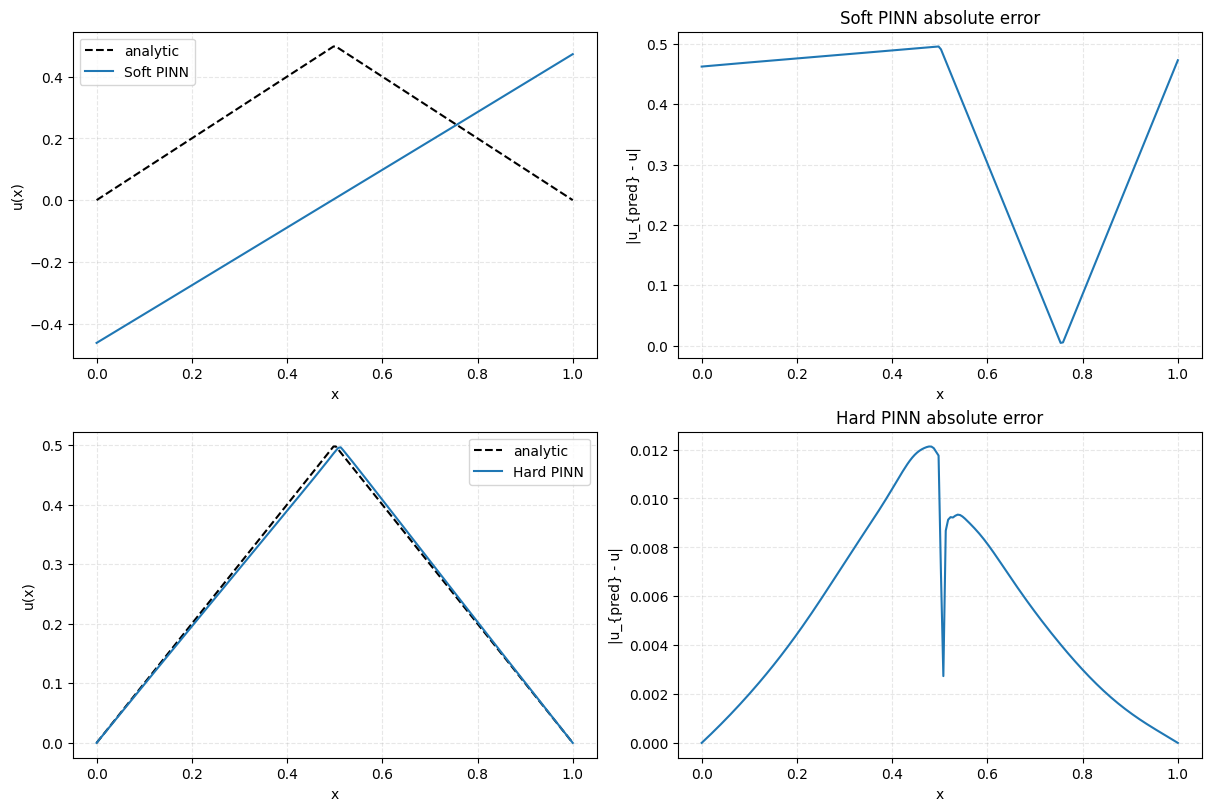

In [26]:
def plot_solution(x, pred, truth, error, axes_row, label):
    axes_row[0].plot(x, truth, "k--", label="analytic")
    axes_row[0].plot(x, pred, label=label)
    axes_row[0].set_xlabel("x")
    axes_row[0].set_ylabel("u(x)")
    axes_row[0].legend()
    axes_row[0].grid(True, ls="--", alpha=0.3)

    axes_row[1].plot(x, error)
    axes_row[1].set_title(f"{label} absolute error")
    axes_row[1].set_xlabel("x")
    axes_row[1].set_ylabel("|u_{pred} - u|")
    axes_row[1].grid(True, ls="--", alpha=0.3)

Xs, soft_pred, soft_truth, soft_err = soft_eval
Xh, hard_pred, hard_truth, hard_err = hard_eval

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
plot_solution(Xs, soft_pred, soft_truth, soft_err, axes[0], "Soft PINN")
plot_solution(Xh, hard_pred, hard_truth, hard_err, axes[1], "Hard PINN")
plt.show()


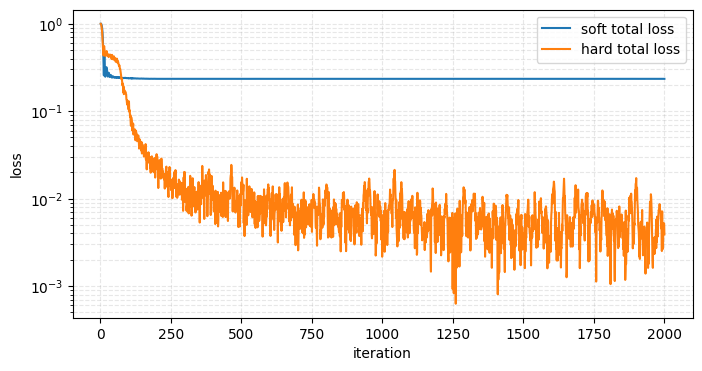

In [27]:
def history_to_frame(history, label):
    frame = pd.DataFrame(history)
    frame["label"] = label
    return frame

soft_df = history_to_frame(soft_history, "soft")
hard_df = history_to_frame(hard_history, "hard")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(soft_df["step"], soft_df["loss"], label="soft total loss")
ax.plot(hard_df["step"], hard_df["loss"], label="hard total loss")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.legend()
ax.grid(True, which="both", ls="--", alpha=0.3)
plt.show()


## Curriculum PINN (viscous continuation)
We add a viscous term $\epsilon u_{xx}$ so the residual becomes $|u_x|^2 - 1 - \epsilon u_{xx} = 0$,
then anneal $\epsilon$ from a large value to zero to warm-start the eikonal solve.


In [28]:
eps_schedule = [1.0, 0.3, 0.1, 0.03, 0.01, 0.005]
curr_models, curriculum_history = train_curriculum(
    eps_schedule,
    steps_per_stage=750,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    hard_boundary=False,
    seed=2024,
)
curr_model = curr_models[-1]


[soft eps=1.00e+00] step    1 | total=9.582e-01 | residual=9.369e-01 | bc=2.126e-02
[soft eps=1.00e+00] step  500 | total=2.298e-05 | residual=2.275e-05 | bc=2.326e-07
[soft eps=3.00e-01] step    1 | total=4.213e-01 | residual=4.213e-01 | bc=2.620e-07
[soft eps=3.00e-01] step  500 | total=1.723e-05 | residual=1.688e-05 | bc=3.529e-07
[soft eps=1.00e-01] step    1 | total=1.820e-01 | residual=1.820e-01 | bc=3.398e-05
[soft eps=1.00e-01] step  500 | total=2.569e-04 | residual=2.342e-04 | bc=2.276e-05
[soft eps=3.00e-02] step    1 | total=6.261e-02 | residual=6.261e-02 | bc=5.624e-07
[soft eps=3.00e-02] step  500 | total=1.164e-03 | residual=1.092e-03 | bc=7.185e-05
[soft eps=1.00e-02] step    1 | total=1.539e-02 | residual=1.538e-02 | bc=8.135e-06
[soft eps=1.00e-02] step  500 | total=6.355e-03 | residual=6.278e-03 | bc=7.674e-05
[soft eps=5.00e-03] step    1 | total=8.200e-03 | residual=8.195e-03 | bc=4.731e-06
[soft eps=5.00e-03] step  500 | total=2.174e-03 | residual=2.148e-03 | bc=2.

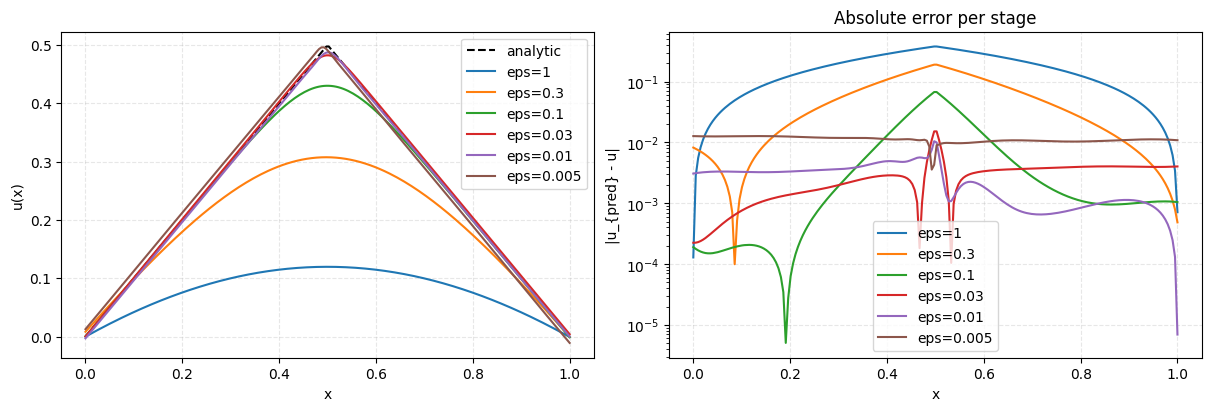

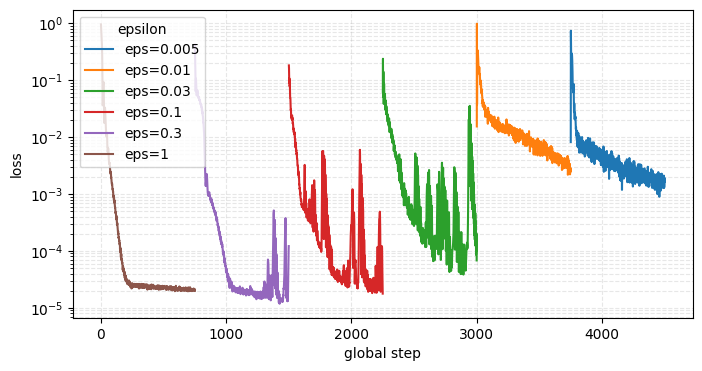

In [29]:
# Evaluate each stage checkpoint on a common grid
stage_evals = []
for eps, model in zip(eps_schedule, curr_models):
    x_s, pred_s, truth_s, err_s = evaluate_model(model)
    stage_evals.append({"eps": eps, "x": x_s, "pred": pred_s, "truth": truth_s, "err": err_s})

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].plot(stage_evals[0]["x"], stage_evals[0]["truth"], "k--", label="analytic")
for eval_row in stage_evals:
    axes[0].plot(eval_row["x"], eval_row["pred"], label=f"eps={eval_row['eps']:g}")
axes[0].set_xlabel("x")
axes[0].set_ylabel("u(x)")
axes[0].legend()
axes[0].grid(True, ls="--", alpha=0.3)

for eval_row in stage_evals:
    axes[1].plot(eval_row["x"], eval_row["err"], label=f"eps={eval_row['eps']:g}")
axes[1].set_title("Absolute error per stage")
axes[1].set_xlabel("x")
axes[1].set_ylabel("|u_{pred} - u|")
axes[1].set_yscale("log")
axes[1].grid(True, ls="--", alpha=0.3)
axes[1].legend()
plt.show()

curr_df = history_to_frame(curriculum_history, "curriculum")
fig, ax = plt.subplots(figsize=(8, 4))
for eps, group in curr_df.groupby("epsilon"):
    ax.plot(group["global_step"], group["loss"], label=f"eps={eps:g}")
ax.set_xlabel("global step")
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.legend(title="epsilon")
ax.grid(True, which="both", ls="--", alpha=0.3)
plt.show()


### Self-adaptive weighting fine-tune (soft BC, fixed data)
We fine-tune the last curriculum stage using trainable per-point weights on fixed interior/boundary/similarity samples, mirroring the TensorFlow self-adaptive scheme. A similarity loss keeps the solution close to the previous stage.


In [30]:
# Prepare fixed datasets from the last two curriculum stages
prev_stage_model = curr_models[-2]
start_model = curr_models[-1]
sa_data = prepare_finetune_data(
    prev_stage_model,
    interior_samples=1024,
    boundary_samples=256,
    similarity_samples=512,
    seed=321,
)

# Fine-tune with adaptive per-point weights
sa_model, sa_weights, sa_history = finetune_self_adaptive(
    model=start_model,
    data=sa_data,
    steps=5000,
    lr_model=5e-4,
    lr_weights=5e-4,
    seed=99,
)


[self-adapt] step    1 | total=9.611e-03 | res=9.470e-03 | bc=1.397e-04 | sim=1.678e-06 | w_mean=(1.00, 1.00)
[self-adapt] step  200 | total=8.920e-03 | res=8.885e-03 | bc=3.405e-05 | sim=5.873e-07 | w_mean=(1.01, 1.01)
[self-adapt] step  400 | total=8.300e-03 | res=8.267e-03 | bc=3.259e-05 | sim=5.663e-07 | w_mean=(1.02, 1.02)
[self-adapt] step  600 | total=7.442e-03 | res=7.409e-03 | bc=3.234e-05 | sim=5.669e-07 | w_mean=(1.02, 1.02)
[self-adapt] step  800 | total=6.604e-03 | res=6.570e-03 | bc=3.309e-05 | sim=5.776e-07 | w_mean=(1.03, 1.02)
[self-adapt] step 1000 | total=5.961e-03 | res=5.925e-03 | bc=3.538e-05 | sim=6.037e-07 | w_mean=(1.03, 1.03)
[self-adapt] step 1200 | total=5.483e-03 | res=5.443e-03 | bc=3.912e-05 | sim=6.449e-07 | w_mean=(1.04, 1.03)
[self-adapt] step 1400 | total=5.101e-03 | res=5.054e-03 | bc=4.631e-05 | sim=7.182e-07 | w_mean=(1.05, 1.04)
[self-adapt] step 1600 | total=4.807e-03 | res=4.770e-03 | bc=3.671e-05 | sim=6.239e-07 | w_mean=(1.06, 1.06)
[self-adap

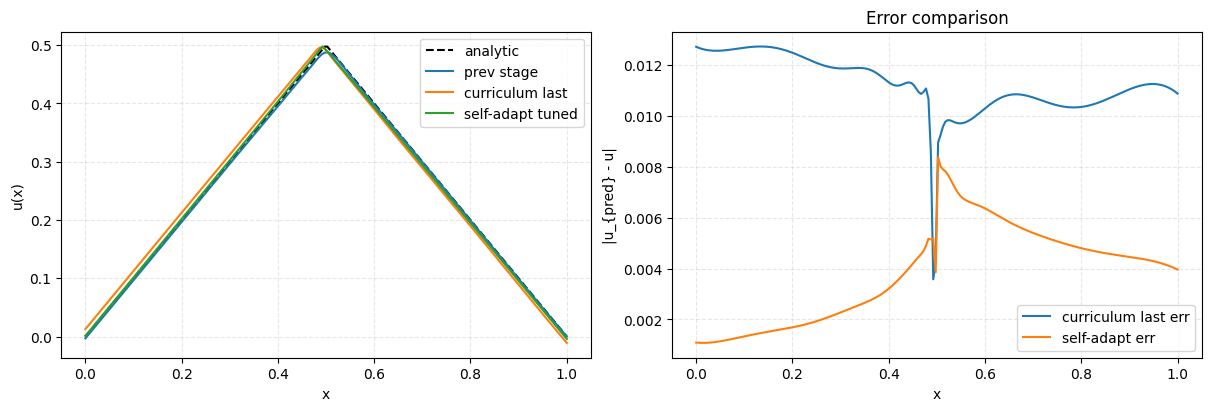

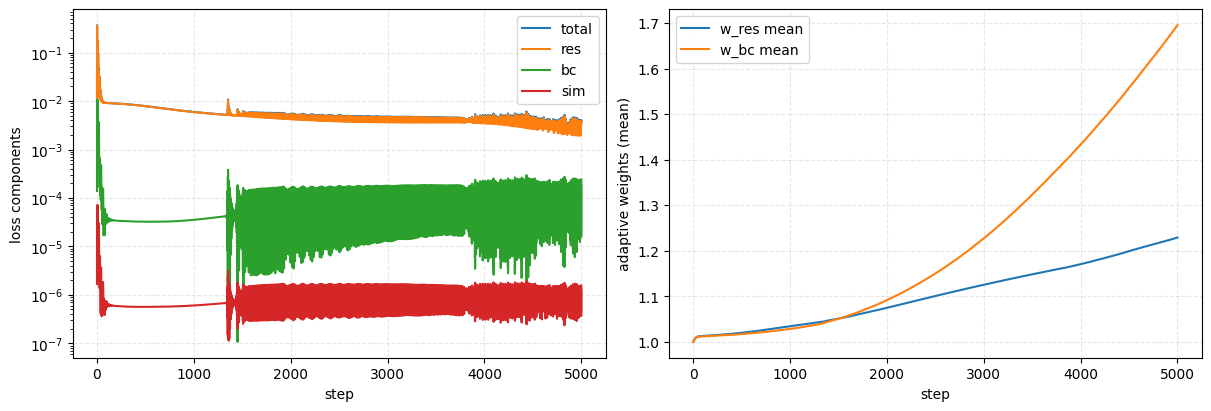

In [31]:
# Compare previous stage, start, and self-adaptive tuned solutions
x_prev, prev_pred, truth_prev, prev_err = evaluate_model(prev_stage_model)
x_start, start_pred, truth_start, start_err = evaluate_model(start_model)
x_sa, sa_pred, truth_sa, sa_err = evaluate_model(sa_model)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].plot(x_sa, truth_sa, "k--", label="analytic")
axes[0].plot(x_prev, prev_pred, label="prev stage")
axes[0].plot(x_start, start_pred, label="curriculum last")
axes[0].plot(x_sa, sa_pred, label="self-adapt tuned")
axes[0].set_xlabel("x")
axes[0].set_ylabel("u(x)")
axes[0].legend()
axes[0].grid(True, ls="--", alpha=0.3)

axes[1].plot(x_start, start_err, label="curriculum last err")
axes[1].plot(x_sa, sa_err, label="self-adapt err")
axes[1].set_xlabel("x")
axes[1].set_ylabel("|u_{pred} - u|")
axes[1].set_title("Error comparison")
axes[1].legend()
axes[1].grid(True, ls="--", alpha=0.3)
plt.show()

sa_df = history_to_frame(sa_history, "self_adaptive")
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].plot(sa_df["step"], sa_df["loss"], label="total")
axes[0].plot(sa_df["step"], sa_df["residual"], label="res")
axes[0].plot(sa_df["step"], sa_df["boundary"], label="bc")
axes[0].plot(sa_df["step"], sa_df["similarity"], label="sim")
axes[0].set_xlabel("step")
axes[0].set_ylabel("loss components")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True, ls="--", alpha=0.3)

axes[1].plot(sa_df["step"], sa_df["w_res_mean"], label="w_res mean")
axes[1].plot(sa_df["step"], sa_df["w_bc_mean"], label="w_bc mean")
# axes[1].plot(sa_df["step"], sa_df["w_sim_mean"], label="w_sim mean")
axes[1].set_xlabel("step")
axes[1].set_ylabel("adaptive weights (mean)")
axes[1].legend()
axes[1].grid(True, ls="--", alpha=0.3)
plt.show()
